# Big-Data Analytics Group Project FS21

---

<b>Project Group 1:</b> Georgios Anagnostou, Juliana Bennett, Yung-Hsin Chen, Kevin Streiter, and Denys Trieskunov

# Introduction
When choosing a topic for this project, our group was well aware of the fatigue that the review of yet another study over Coronavirus might elicit, but even as summer holidays now approach, we all find ourselves still asking the same questions of 2020: When can we finally move forward from this crisis? When will "normalcy" return? And specifically within academia: when can we finally log off of Zoom and productively learn together as students and professors face-to-face again? As a group, we attempted to find an answer to these questions by analyzing the vaccination rollercoaster of the past months, and in turn, predict a timeline. Our data process proceeded as follows: <br>
What is meaningful to us as a group is applying the data science pipeline to a data set that contains features from which valuable information can be extracted. <br>
Consequently, we selected the Covid-19 data set from Our World in Data (https://github.com/owid/covid-19-data.git). It includes data on confirmed cases, deaths, hospitalizations, testing, and vaccinations as well as other variables of potential interest. These data come from all the countries of six continents that provided the relevant information and were collected from 20th May 2020 to 26th January 2021. The dataset is of size (90109 x 59). <br>
Our goal is to predict the future number of new cases per million people in the period of 1st June 2021 - 31st August 2021. Additionaly, to take a subset of this large dataset and make our findings more interesting we focus on the data provided by Switzerland and predict the future new cases of Covid-19. 

# Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import (DAILY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import seaborn as sn
from datetime import datetime

# Import Data


In [ ]:
# import data set
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/Covid_vaccination/"
covid = pd.read_excel(path + "owid-covid-data.xlsx")
# covid = pd.read_csv('C:/Users/George/Big Data Analytics/owid-covid-data.csv')
covid_original = covid.copy()
covid.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(90109, 59)

# Exploratory Data Analysis

## General Inferences

Here we outline some general metrics from our data set

In [ ]:
# get all continent names (without na values)
continent_names = covid['continent'].dropna().unique()

# get only continent & world data
continents = covid.loc[covid['location'].isin(continent_names)]

# print all coontinents
print(f"The following continents are listed in our data set: {continent_names}")

The following continents are listed in our data set: ['Asia' 'Europe' 'Africa' 'North America' 'South America' 'Oceania']


In [ ]:
# group by all countries
country_groups = covid.groupby(['location', 'continent'])

# print all cases
total_cases = country_groups['total_cases'].max().sum()
print(f" Total cases:                            {total_cases: .1e}")

# compare world deaths with continent and country deaths
total_deaths = country_groups['total_deaths'].max().sum()
print(f" Total deaths:                           {total_deaths: .1e}")

# print total tests
total_tests = country_groups['total_tests'].max().sum()
print(f" Total tests:                            {total_tests: .1e}\n")

# print probability of positive test result
print(f" Probability of positive test result:    {total_cases / total_tests * 100: .0f} %")

# print fraction of already tested population
population = country_groups['population'].max().sum()
print(f" Fraction of tested people (in theory):  {total_tests / population * 100: .0f} %")

# print fraction of already vaccinated population world
fully_vacc = country_groups['people_fully_vaccinated'].max().sum()
print(f" Fraction of fully vaccinated people:    {fully_vacc / population * 100: .0f} %")

# print hosp patients
hosp = country_groups['hosp_patients'].mean().mean()
print(f" Fraction of hosp patients on average:   {hosp / population * 100: .1e} %")

# print icu patients
icu = country_groups['icu_patients'].mean().mean()
print(f" Fraction of icu patients on average:    {icu / population * 100: .1e} %")

 Total cases:                             1.7e+08
 Total deaths:                            3.4e+06
 Total tests:                             2.1e+09

 Probability of positive test result:     8 %
 Fraction of tested people (in theory):   27 %
 Fraction of fully vaccinated people:     5 %
 Fraction of hosp patients on average:    6.8e-05 %
 Fraction of icu patients on average:     1.6e-05 %


## Histogram plots
Here we compare the vaccination rate, contamination rate as well as death and positive rate per continent. We are interested in finding associations between those attributes and get a general idea how the data is distributed among the continents

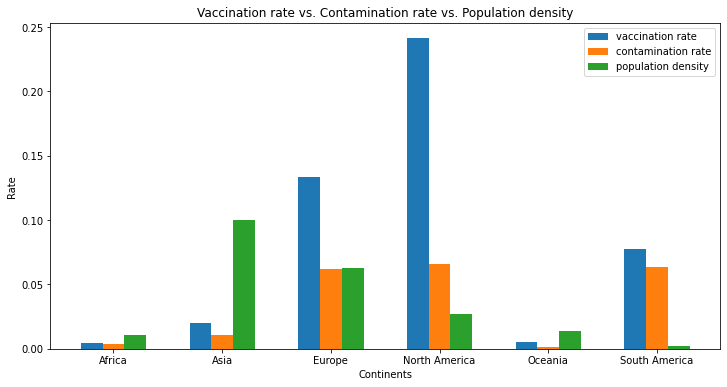

In [ ]:
# plot vaccination rate vs. contamination rate vs. population density per continent

fully_vacc = country_groups['people_fully_vaccinated'].max().groupby('continent').sum()
population = country_groups['population'].max().groupby('continent').sum()
total_cases = country_groups['total_cases'].max().groupby('continent').sum()
density = country_groups['population_density'].max().groupby('continent').mean()

plt.figure(figsize=(12,6))
width = 0.2
bar1 = np.arange(len(population.values))
bar2 = [i + width for i in bar1]
bar3 = [i + width for i in bar2]

plt.bar(bar1, fully_vacc.values / population.values , width, label='vaccination rate')
plt.bar(bar2, total_cases.values / population.values, width, label='contamination rate')
plt.bar(bar3, density / 10000, width, label='population density')

plt.title('Vaccination rate vs. Contamination rate vs. Population density')
plt.xticks(bar1 + width, population.keys())
plt.xlabel('Continents')
plt.ylabel('Rate')
plt.legend()
plt.show()

### Findings from first Histogram plot
We can clearly see that North America has the highest vaccination rate (> 25%) whereas Africa has the lowest. From this histogram plot we can also not infer that a higher population density leads to more cases. Especially considering Asia, which has the highest population density but a much lower contamination rate than Europe. This is just a generalization as we have not analyzed the fraction of population living in high density areas but it gives a good overview of the vaccination progress of each continent.


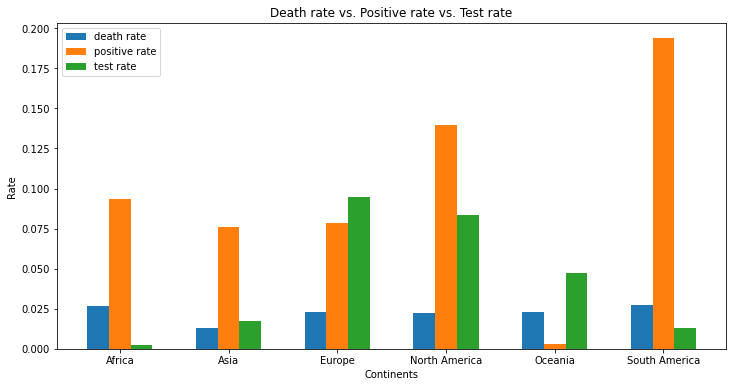

In [ ]:
# plot death rate vs. positive rate vs. population density per continent

total_deaths = country_groups['total_deaths'].max().groupby('continent').sum()
positive_rate = country_groups['positive_rate'].mean().groupby('continent').mean()
total_tests = country_groups['total_tests'].max().groupby('continent').sum()

plt.figure(figsize=(12,6))
width = 0.2
bar1 = np.arange(len(population.values))
bar2 = [i + width for i in bar1]
bar3 = [i + width for i in bar2]

plt.bar(bar1, total_deaths / total_cases , width, label='death rate')
plt.bar(bar2, positive_rate, width, label='positive rate')
plt.bar(bar3, total_tests / population / 10, width, label='test rate')

plt.title('Death rate vs. Positive rate vs. Test rate')
plt.xticks(bar1 + width, population.keys())
plt.xlabel('Continents')
plt.ylabel('Rate')
plt.legend()
plt.show()

### Findings from second Histogram plot

The death rate in every continent is approximately on a similar level. Considering the test rate: North America and Europe have conducted the most tests but interestingly the positive rate is higher in South America. Even Africa where the test rate is the lowest has a higher positive rate than Europe. This could be due to the fact that Africa has only limited ressources and can only conduct tests if it is really indicated.



## Correlation Matrix

In order to analyse the association between the variables in the dataset a correlation matrix has been created. Only the relative attributes have been selected as absolute attributes would deviate the result.


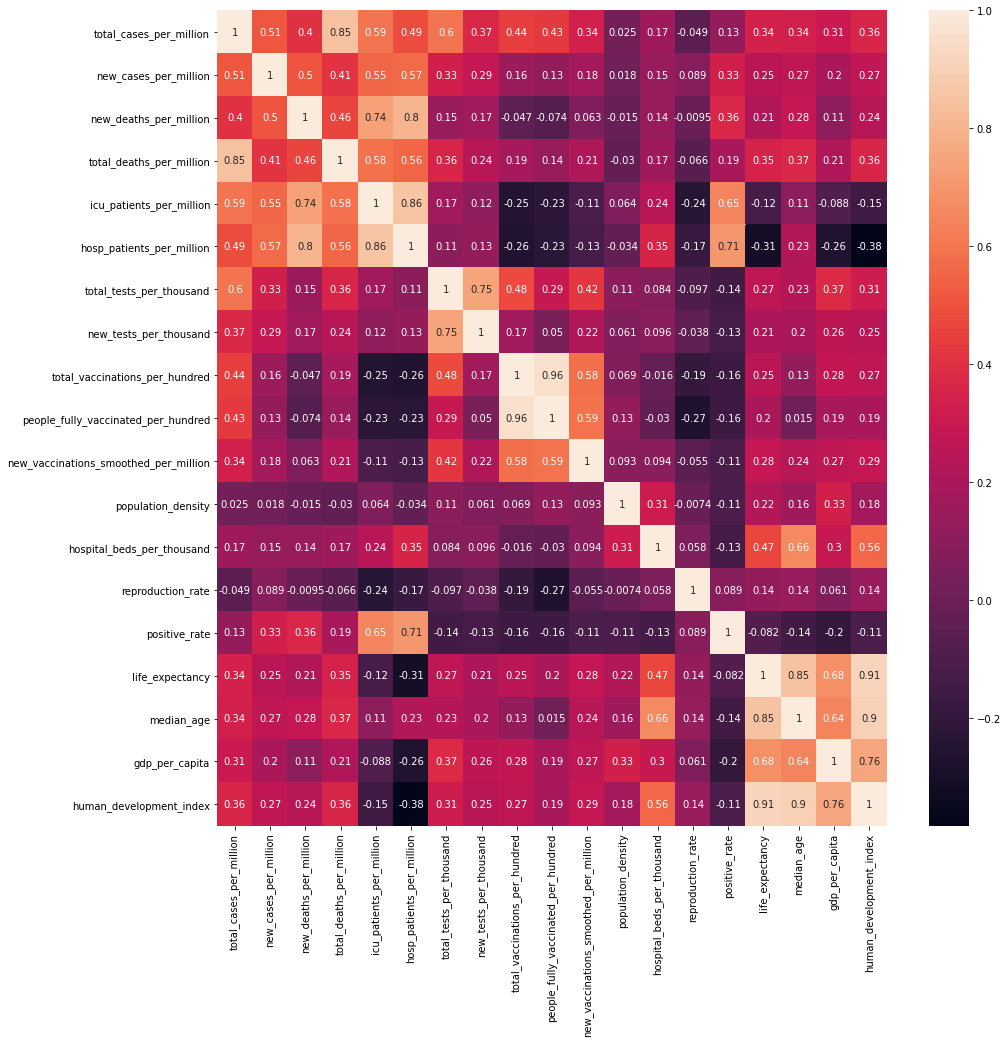

In [ ]:
# create correlation matrix with interesting attributes from the World

columns = ['total_cases_per_million', 'new_cases_per_million', 'new_deaths_per_million', 'total_deaths_per_million', 'icu_patients_per_million', 'hosp_patients_per_million', 'total_tests_per_thousand', 'new_tests_per_thousand', 'total_vaccinations_per_hundred', 'people_fully_vaccinated_per_hundred', 'new_vaccinations_smoothed_per_million', 'population_density', 'hospital_beds_per_thousand', 'reproduction_rate','positive_rate', 'life_expectancy', 'median_age', 'gdp_per_capita', 'human_development_index']
data = country_groups.obj
data = data[columns]

plt.figure(figsize=(15,15))
corr_matrix = data.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

### Findings from correlation matrix using World data


*   Strong correlation (> 0.7) between death rate and icu / hosp patients
*   Strong correlation (0.85) between death rate and total cases
*   Correlation between positive rate and icu / hosp patients (~ 0.7)
*   Negative correlation between poverty and median age, life expectancy and development index (~ -0.7)
*   No significant correlation between reproduction rate and cases or death rate and other attributes
*   No significant correlation between population density and cases or death rate and other attributes
*   No significan correlation between fully vaccinated people and cases or deaths


In general, it seems that on the basis of data set the amount of new covid-19 cases cannot be reduced on the basis of fully vaccinated people. Further studies should be conducted in the future as the vaccination rate worldwide is still low.

### Vaccination rate

To investigate the correlation even further, we analyze the countries with the highest and lowest vaccination rate in this part.

In [ ]:
# find countries with highest and lowest vaccination rate

# consider only countries with more than 5 Million inhabitants due to representative reasons
data = covid[covid['population'] >= 5000000]

# drop countries with nan values in relevant column
data = data.dropna(subset = ["people_fully_vaccinated_per_hundred"])

# ingore continent data
data = data[~data["location"].isin(continent_names)]

# group by country to compute the vaccination rate
country_grouped_data = data.groupby('location', sort=False).apply(lambda x: x["people_fully_vaccinated"].max() / x['population'].max()).reset_index(name ='vacc_rate')
 
# compute row index of highest and lowest vaccination rate
highest_vacc_idx = country_grouped_data['vacc_rate'].argmax()
lowest_vacc_idx = country_grouped_data['vacc_rate'].argmin()

# get row from computed index
row_highest = country_grouped_data.iloc[highest_vacc_idx]
row_lowest = country_grouped_data.iloc[lowest_vacc_idx]

print(f"Highest vaccination rate ({row_highest['vacc_rate']:.2} %) in following country: {row_highest['location']}")
print(f"Lowest vaccination rate ({row_lowest['vacc_rate']:.2} %) in following country: {row_lowest['location']}\n")

# compute 20 highest & lowest vaccinate rate countries
higest_vacc_countries = country_grouped_data.nlargest(20, 'vacc_rate')
lowest_vacc_countries = country_grouped_data.nsmallest(20, 'vacc_rate')

print(f"20 countries with highest vaccination rate: \n")
print(higest_vacc_countries)

print(f"\n20 countries with lowest vaccination rate: \n")
print(lowest_vacc_countries)

Highest vaccination rate (0.59 %) in following country: Israel
Lowest vaccination rate (6.7e-05 %) in following country: Cameroon

20 countries with highest vaccination rate: 

                location  vacc_rate
37                Israel   0.590490
14                 Chile   0.399018
81  United Arab Emirates   0.387904
83         United States   0.382490
82        United Kingdom   0.312870
33               Hungary   0.291377
65                Serbia   0.271262
67             Singapore   0.246232
19               Denmark   0.194020
28                Greece   0.167263
71                 Spain   0.164631
63               Romania   0.158118
38                 Italy   0.157126
62              Portugal   0.144918
24        European Union   0.143560
75           Switzerland   0.142909
26                France   0.139889
61                Poland   0.137989
78                Turkey   0.137209
7                Belgium   0.134663

20 countries with lowest vaccination rate: 

        location  vac

We have now discovered that Isreal has already vaccinated 60% of all inhabitants. In comparison, there are still many countries which haven't been able to keep up with the vaccinations. In order to analyse the attribute correlations a bit closer we analyze only the countries which have the 20 highest vaccination rates.

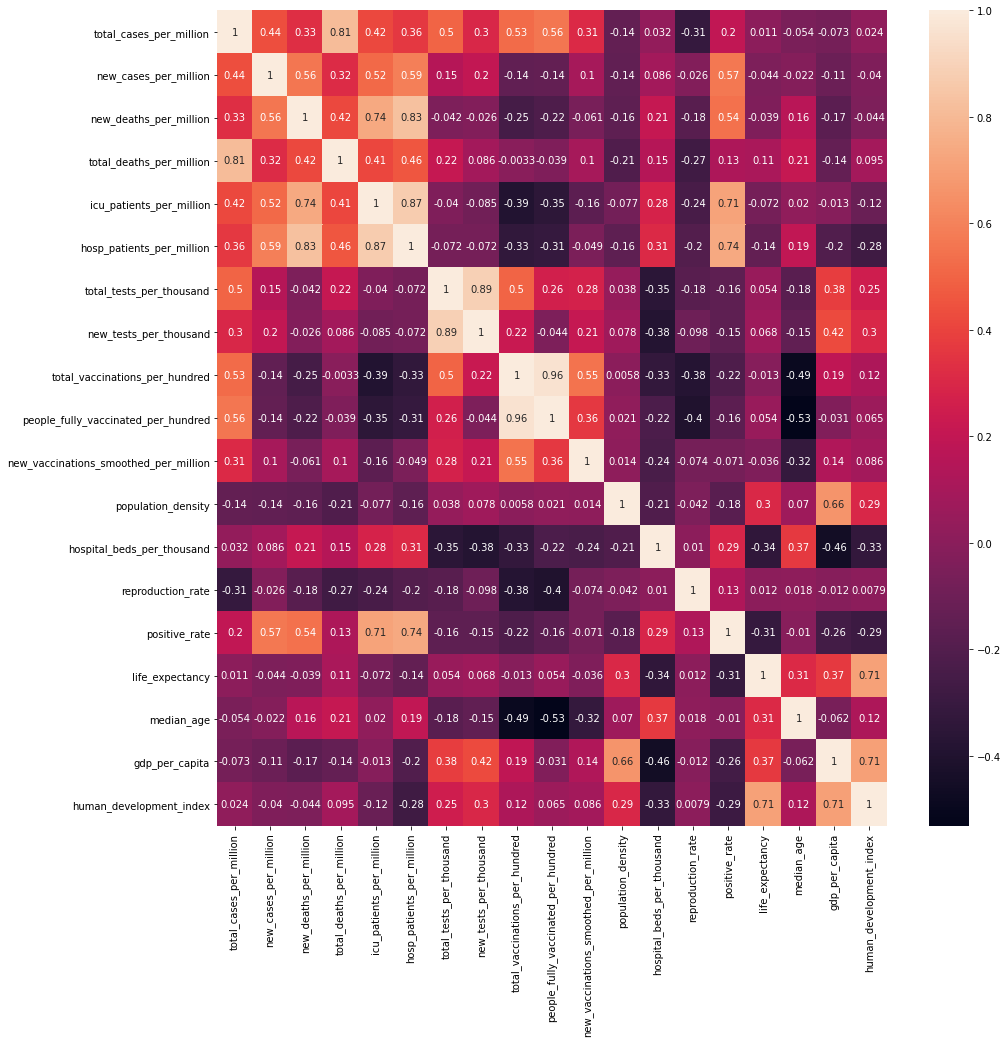

In [ ]:
# create correlation matrix with interesting attributes from the countries with the 20 highest vaccination rates

data = covid.loc[covid['location'].isin(higest_vacc_countries['location'].unique())]
columns = ['total_cases_per_million', 'new_cases_per_million', 'new_deaths_per_million', 'total_deaths_per_million', 'icu_patients_per_million', 'hosp_patients_per_million', 'total_tests_per_thousand', 'new_tests_per_thousand', 'total_vaccinations_per_hundred', 'people_fully_vaccinated_per_hundred', 'new_vaccinations_smoothed_per_million', 'population_density', 'hospital_beds_per_thousand', 'reproduction_rate','positive_rate', 'life_expectancy', 'median_age', 'gdp_per_capita', 'human_development_index']
data = data[columns]

plt.figure(figsize=(15,15))
corr_matrix = data.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

### Findings from correlation matrix using only 20 countries with highest vaccination rate

Most correlations remain as stated in the world view. Interestingly, it seems that the median age is not correlated with the human development index and life expectancy anymore as it has been apparent in the world data. Moreover, we can see a weak negative correlation (~ -0.6) between the median age and the fully vaccinated people.

## Trend Analysis
In this section we try to get an idea how the Covid-19 pandemic has been evolving over time. We are particularly interested in the progress of the vaccination rate in relation with the number of cases among the continents. In a later section we analyze specifically the situation in selected countries.

### Total Cases per Continent

In this trend plot we will outline the total cases per million inhabitats per continent

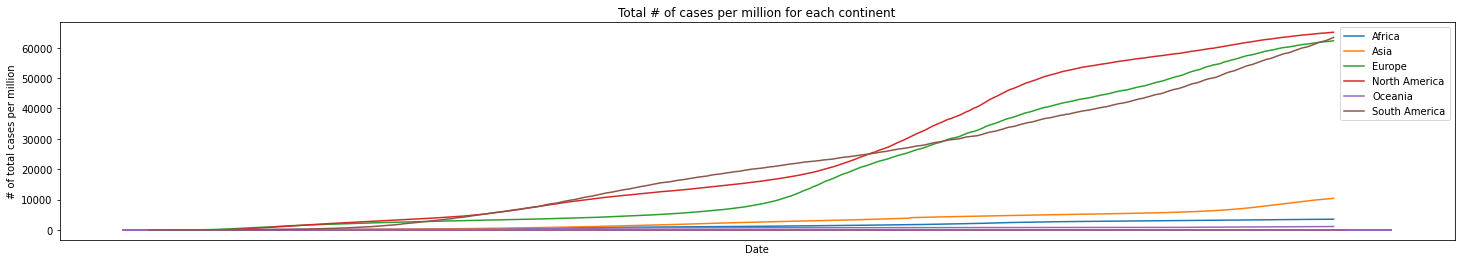

In [ ]:
# plot total cases per continent
rule = rrulewrapper(DAILY, interval=10)
loc = RRuleLocator(rule)
fig, ax = plt.subplots(figsize=(25,4))

# plot lines
for name, data in continents.groupby(['location']):
  plt.plot_date(data['date'], data['total_cases_per_million'], '-', label=name)
  
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_tick_params(rotation=60, labelsize=10)
ax.legend()
plt.title('Total # of cases per million for each continent')
plt.xlabel('Date')
plt.ylabel('# of total cases per million')
plt.show()

The plot reveals that the continents North America, South America and Europe have been suffering from covid the most. The numbers from Europe and North America seem to be increasing less rapidly at the moment compared to South America where a steeper increase can be seen. The other continents definitely show significantly less cases.

### Total Death per Continent

In this trend plot we will outline the total death cases per million inhabitats per continent

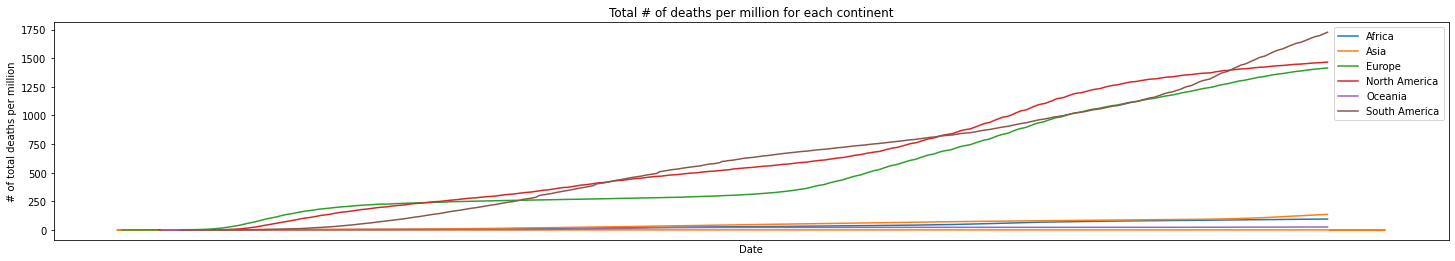

In [ ]:
# plot total deaths per continent
fig, ax = plt.subplots(figsize=(25,4))

# plot lines
for name, data in continents.groupby(['location']):
  plt.plot_date(data['date'], data['total_deaths_per_million'], '-', label=name)
  
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_tick_params(rotation=60, labelsize=10)
ax.legend()
plt.title('Total # of deaths per million for each continent')
plt.xlabel('Date')
plt.ylabel('# of total deaths per million')
plt.show()

We can observe similar behavior as above. The number of deaths in South America is rising sharply in comparison with North America and Europe where a plateau has been reached. The other continents show a similar numbers as visualized in the the total cases plot.

### New Vaccinations per Continent

In this trend plot we will outline the new vaccinations per million inhabitats per continent

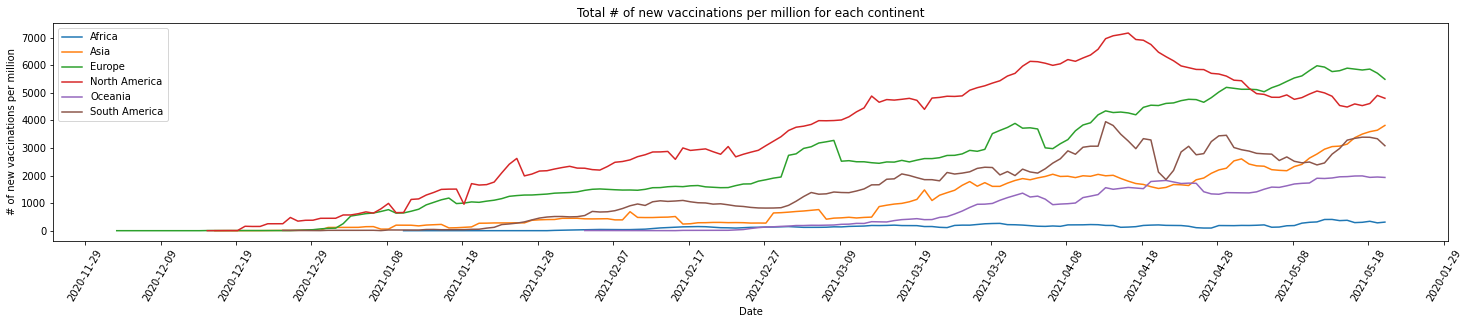

In [ ]:
# plot new vaccinations per million per continent
fig, ax = plt.subplots(figsize=(25,4))

# plot lines
for name, data in continents.groupby(['location']):
  plt.plot_date(data['date'], data['new_vaccinations_smoothed_per_million'], '-', label=name)
  
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_tick_params(rotation=60, labelsize=10)
ax.legend()
plt.title('Total # of new vaccinations per million for each continent')
plt.xlabel('Date')
plt.ylabel('# of new vaccinations per million')
plt.show()

In North America, the vaccination rate was already very high earlier than in other continents, although it is interesting to note that the willingness to vaccinate is currently declining again. In Europe, we see a steady increase over time. In South America, the number of new vaccinations fluctuates greatly compared to the other continents. Africa has not been able to increase the number of new vaccinations. Asia's vaccination campaign got off to a slow start, but for the past month, the number of new vaccinations per million population has been rising the fastest 

### People fully vaccinated per Continent

In this trend plot we will outline the people who have been fully vaccinated per continent

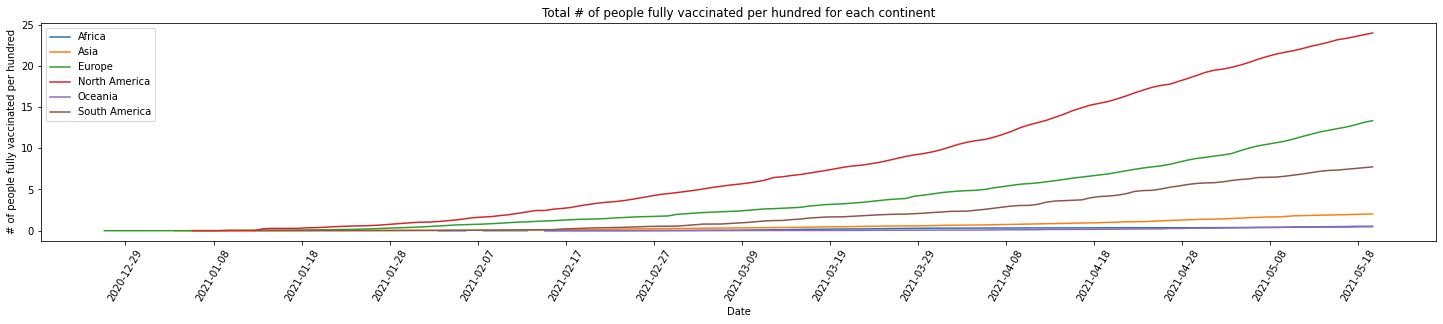

In [ ]:
# plot people fully vaccinated per hundred per continent
fig, ax = plt.subplots(figsize=(25,4))

# plot lines
for name, data in continents.groupby(['location']):
  plt.plot_date(data['date'], data['people_fully_vaccinated_per_hundred'], '-', label=name)
  
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_tick_params(rotation=60, labelsize=10)
ax.legend()
plt.title('Total # of people fully vaccinated per hundred for each continent')
plt.xlabel('Date')
plt.ylabel('# of people fully vaccinated per hundred')
plt.show()

Here we can see a steady increase in all continents with the exception of Africa. We can also see that in Europe, in particular, a late but currently strongest increase has taken place. In North America, the largest proportion of the population has been vaccinated compared to the other continents.

### Total Cases per million per Country

In this trend plot we will outline total casses per million for selected countries.

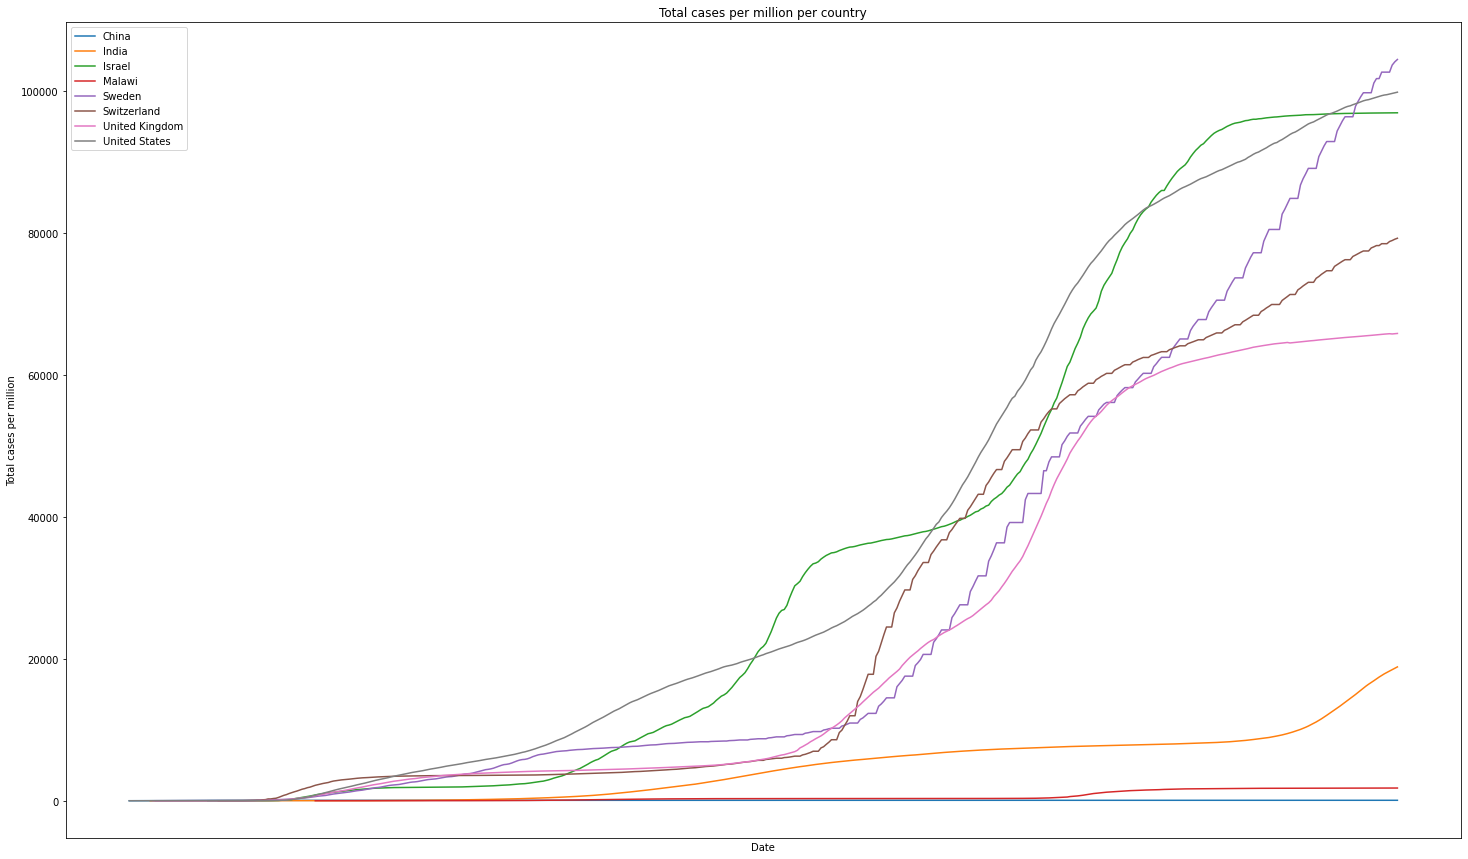

In [ ]:
# plot total cases per million per country
fig, ax = plt.subplots(figsize=(25,15))

countries = covid.loc[covid['location'].isin(['Switzerland', 'Malawi','United States', 'China', 'India', 'United Kingdom', 'Sweden', 'Israel'])]

# plot lines
for name, data in countries.groupby(['location']):
  plt.plot_date(data['date'], data['total_cases_per_million'], '-', label=name)
  
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_tick_params(rotation=60, labelsize=10)
ax.legend()
plt.title('Total cases per million per country')
plt.xlabel('Date')
plt.ylabel('Total cases per million')
plt.show()

In this chart we see that Israel's vaccination campaign is already paying off with 60% already vaccinated. Since mid-March, the number of new covid-19 cases has stagnated. Cases in China seem to have remained low since the beginning of the pandemic. India has experienced a late surge. The increase in Sweden has not been significantly slowed so far. In Switzerland, the curve is currently leveling off again. In the USA, too, the number of vaccinations seems to be reflected in the number of cases. Malawi, the country with the lowest vaccination rate also does not seem to record many cases.

### Switzerland vs. Israel

In this section, we will look at the data from Isreal and Switzerland.

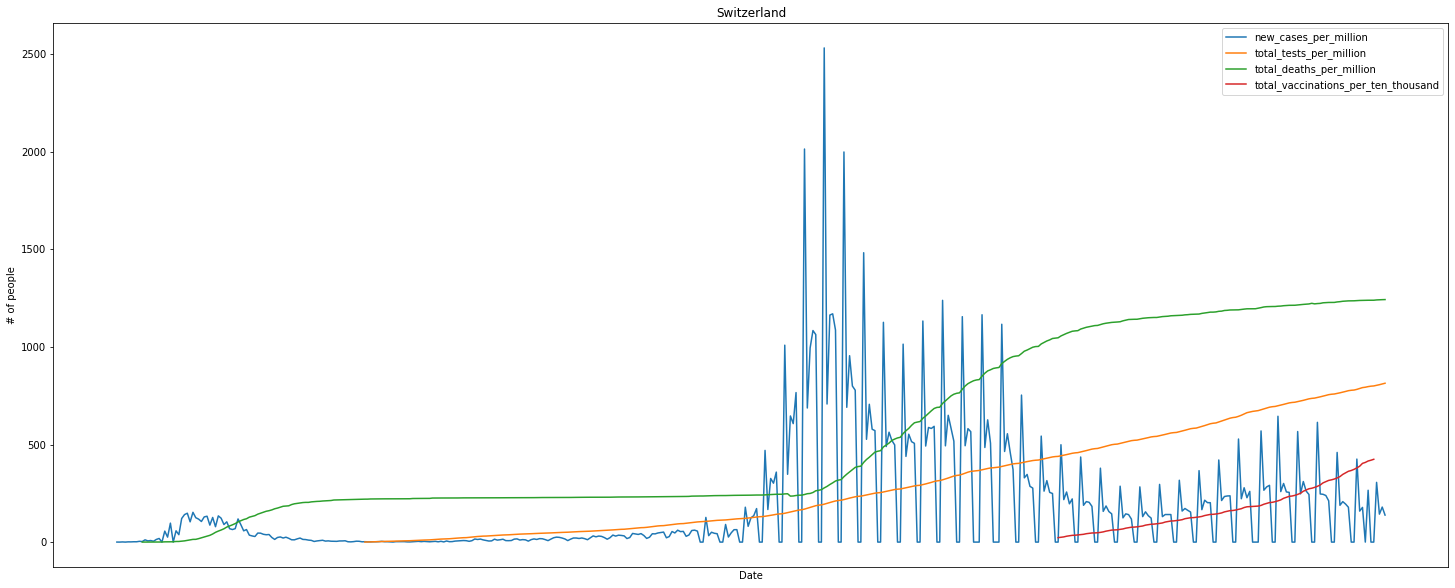

In [ ]:
# plot hospital overload vs. death rate
fig, ax = plt.subplots(figsize=(25,10))

swiss = covid.loc[covid['location'] == 'Switzerland']

plt.plot_date(swiss['date'], swiss['new_cases_per_million'], '-', label='new_cases_per_million')
plt.plot_date(swiss['date'], swiss['total_tests_per_thousand'], '-', label='total_tests_per_million')
plt.plot_date(swiss['date'], swiss['total_deaths_per_million'], '-', label='total_deaths_per_million')
plt.plot_date(swiss['date'], swiss['total_vaccinations_per_hundred'] * 10, '-', label='total_vaccinations_per_ten_thousand')
  
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_tick_params(rotation=60, labelsize=10)
ax.legend()
plt.title('Switzerland')
plt.xlabel('Date')
plt.ylabel('# of people')
plt.show()

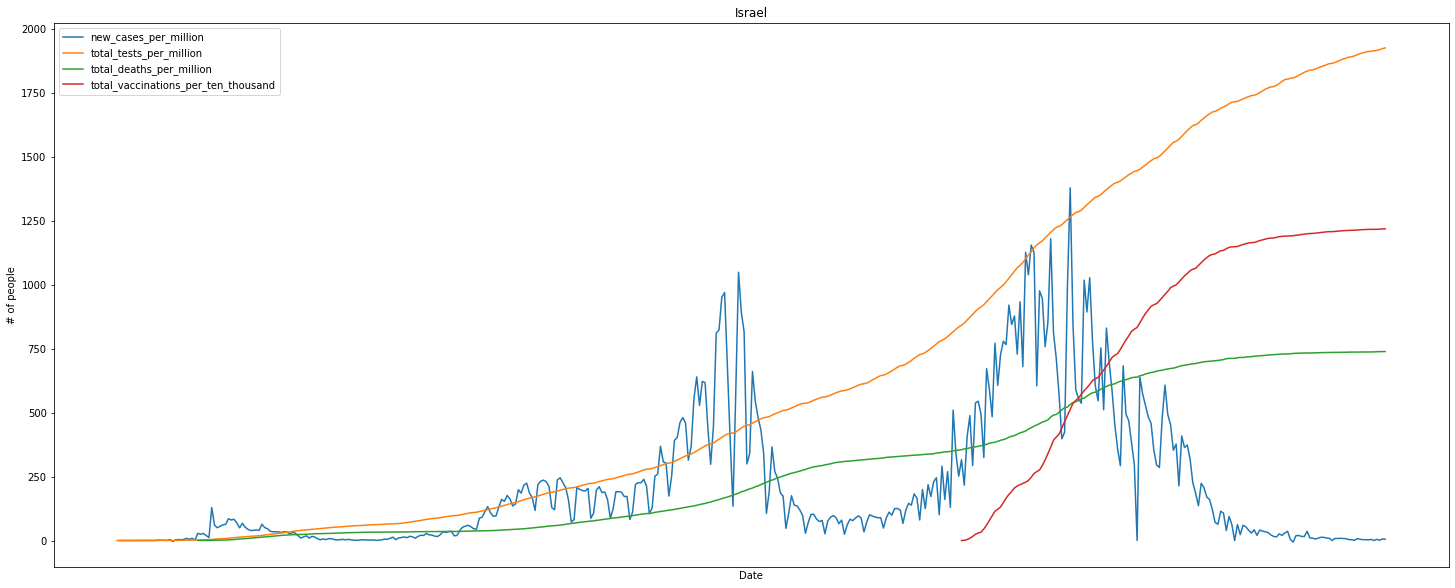

In [ ]:
# plot hospital overload vs. death rate
fig, ax = plt.subplots(figsize=(25,10))

israel = covid.loc[covid['location'] == 'Israel']

plt.plot_date(israel['date'], israel['new_cases_per_million'], '-', label='new_cases_per_million')
plt.plot_date(israel['date'], israel['total_tests_per_thousand'], '-', label='total_tests_per_million')
plt.plot_date(israel['date'], israel['total_deaths_per_million'], '-', label='total_deaths_per_million')
plt.plot_date(israel['date'], israel['total_vaccinations_per_hundred'] * 10, '-', label='total_vaccinations_per_ten_thousand')
  
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_tick_params(rotation=60, labelsize=10)
ax.legend()
plt.title('Israel')
plt.xlabel('Date')
plt.ylabel('# of people')
plt.show()

In Switzerland, a zig-zag behavior of new cases can be seen that is periodically repeated. This can be explained by the higher number of tests during the week in comparison with weekend testing. This is also evident in Israel. Furthermore, the amount of new cases per million reveals also the typical wave behaviour of the covid-19 pandemic. The second wave in Switzerland uncovered much more positive cases than Isreal has ever conducted. After the second wave, new cases had been slightly reduced but stayed high whereas Isreal had few new cases during the second and third wave. The third wave in Israel is much more prominent than in Swizerland. Switzerland's vaccination campain started approximately one month later and was not as effective as in Isreal during this time. At the moment Israel daily applied vaccinations have slowed down. This could be because already 60 % of the population has already been vaccinated and the remaining population does not seem to be ready for vaccination yet. Also evident is that the total deaths per million is always increasing the most after a prominent wave has been conducted (slight shift in time).

# Data preprocessing


In the data preprocessing, we intend to preserve as many rows as we can and thus, we eliminate the null rows in the dependent variable, and replace the average value with the null values for the other variables.

First of all, leave only the independent variables of the regression in the dataset and drop the rows where *new_cases_smoothed_per_million* (the depenendent variable) is null.

In [ ]:
def convert_to_date(value: str):
  date_string = value[2:4] + '/' + value[5:7] + '/' + value[8:10]
  date = datetime.strptime(date_string, '%y/%m/%d')
  return date

covid['date'] = covid.apply(lambda x: convert_to_date(str(x['date'])), axis=1)
var = ['date', 'country', 'total_cases_per_million', 'total_deaths_per_million', 'reproduction_rate', 'total_tests_per_thousand', 'new_tests_smoothed_per_thousand', 
       'positive_rate', 'total_vaccinations_per_hundred', 'stringency_index', 'population', 'population_density',  
       'human_development_index', 'new_vaccinations_smoothed', 'life_expectancy', 'median_age', 'aged_65_older', 'gdp_per_capita', 'extreme_poverty',
     'new_cases_smoothed_per_million']
covid.rename(columns = {"location": "country"}, inplace = True)
covid_set = covid[var][covid['new_cases_smoothed_per_million'].isna() == False]
covid_set.head()

,date,country,total_cases_per_million,total_deaths_per_million,reproduction_rate,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,total_vaccinations_per_hundred,stringency_index,population,population_density,human_development_index,new_vaccinations_smoothed,life_expectancy,median_age,aged_65_older,gdp_per_capita,extreme_poverty,new_cases_smoothed_per_million
5,2020-02-29,Afghanistan,0.026,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,0.511,NaN,64.83,18.6,2.581,1803.987,NaN,0.004
6,2020-03-01,Afghanistan,0.026,NaN,NaN,NaN,NaN,NaN,NaN,27.78,38928341.0,54.422,0.511,NaN,64.83,18.6,2.581,1803.987,NaN,0.004
7,2020-03-02,Afghanistan,0.026,NaN,NaN,NaN,NaN,NaN,NaN,27.78,38928341.0,54.422,0.511,NaN,64.83,18.6,2.581,1803.987,NaN,0.000
8,2020-03-03,Afghanistan,0.051,NaN,NaN,NaN,NaN,NaN,NaN,27.78,38928341.0,54.422,0.511,NaN,64.83,18.6,2.581,1803.987,NaN,0.004
9,2020-03-04,Afghanistan,0.103,NaN,NaN,NaN,NaN,NaN,NaN,27.78,38928341.0,54.422,0.511,NaN,64.83,18.6,2.581,1803.987,NaN,0.011


To prepare the dataset ready for the panel ols, we have to select dates that includes all countries.  After this step, there will be no null values for *new_cases_smoothed_per_million*.  However, there are still null values left for other variables.

In [ ]:
period = []
covid_org = covid_set.copy()
for i in covid_org['date'].unique():
  tmp = covid_org[covid_org['date'] == i]
  if len(tmp) == 199:
    period.append(i)
covid_org = covid_org[covid_org['date'].isin(period)]

In [ ]:
print("new_cases_smoothed_per_million: ", len(covid_org))
print("NUMBERS OF NANS")
print("--------------------------------------------")
for feature in ['new_cases_smoothed_per_million'] + var:
    print(feature, ": ", covid_org[feature].isna().sum())

new_cases_smoothed_per_million:  22885
NUMBERS OF NANS
--------------------------------------------
new_cases_smoothed_per_million :  0
date :  0
country :  0
total_cases_per_million :  0
total_deaths_per_million :  1107
reproduction_rate :  2289
total_tests_per_thousand :  12472
new_tests_smoothed_per_thousand :  10225
positive_rate :  10826
total_vaccinations_per_hundred :  13155
stringency_index :  4136
population :  0
population_density :  1265
human_development_index :  1495
new_vaccinations_smoothed :  7038
life_expectancy :  920
median_age :  1840
aged_65_older :  2070
gdp_per_capita :  1725
extreme_poverty :  8510
new_cases_smoothed_per_million :  0


After elimating the null values in the dependent variables, the null values of the other columns are replaced with average values.

In [ ]:
var_for_avg = [i for i in var if (covid_org[i].isna().sum() != 0 and i not in ['continent', 'tests_units'])]
for feature in var_for_avg:
  covid_org[feature].fillna(covid_org[feature][covid_org[feature].isna() == False].mean(axis=0), inplace = True)

print("new_cases_smoothed_per_million: ", len(covid_org))
print("NUMBERS OF NANS")
print("--------------------------------------------")
for feature in ['new_cases_smoothed_per_million'] + var:
    print(feature, ": ", covid_org[feature].isna().sum())

new_cases_smoothed_per_million:  22885
NUMBERS OF NANS
--------------------------------------------
new_cases_smoothed_per_million :  0
date :  0
country :  0
total_cases_per_million :  0
total_deaths_per_million :  0
reproduction_rate :  0
total_tests_per_thousand :  0
new_tests_smoothed_per_thousand :  0
positive_rate :  0
total_vaccinations_per_hundred :  0
stringency_index :  0
population :  0
population_density :  0
human_development_index :  0
new_vaccinations_smoothed :  0
life_expectancy :  0
median_age :  0
aged_65_older :  0
gdp_per_capita :  0
extreme_poverty :  0
new_cases_smoothed_per_million :  0


# Building the model


The model we chose is panel OLS since we have a time-series dataset.  We have the independent variables as 
total_cases_per_million, total_deaths_per_million, total_tests_per_thousand, new_tests_smoothed_per_thousand, total_vaccinations_per_hundred, stringency_index,  
       new_vaccinations_smoothed, and the dependent variable as new_cases_smoothed_per_million. 

In [ ]:
!pip install linearmodels
!pip install datetime
import numpy as np
from linearmodels import PanelOLS
import statsmodels.api as sm
from linearmodels import RandomEffects
from datetime import timedelta

In [ ]:
reg_data = covid_org.set_index(['country', 'date'])
print(reg_data.head())

                        total_cases_per_million  ...  new_cases_smoothed_per_million
country     date                                 ...                                
Afghanistan 2021-01-26                 1406.430  ...                           2.235
            2021-01-27                 1409.102  ...                           2.114
            2021-01-28                 1410.052  ...                           1.791
            2021-01-29                 1411.285  ...                           1.673
            2021-01-30                 1413.058  ...                           1.648

[5 rows x 18 columns]


In [ ]:
exog_vars = ['total_cases_per_million', 'total_deaths_per_million', 'total_tests_per_thousand', 'new_tests_smoothed_per_thousand', 
       'total_vaccinations_per_hundred', 'stringency_index',  
       'new_vaccinations_smoothed']
exog = sm.add_constant(reg_data[exog_vars]) 

reg = PanelOLS(reg_data.new_cases_smoothed_per_million, exog,  entity_effects=True, drop_absorbed=True)

res = reg.fit(cov_type='clustered', cluster_entity=True)

print(res)

                                PanelOLS Estimation Summary                                 
Dep. Variable:     new_cases_smoothed_per_million   R-squared:                        0.1491
Estimator:                               PanelOLS   R-squared (Between):             -0.1368
No. Observations:                           22885   R-squared (Within):               0.1491
Date:                            Fri, Jun 11 2021   R-squared (Overall):             -0.0251
Time:                                    17:23:21   Log-likelihood                -1.399e+05
Cov. Estimator:                         Clustered                                           
                                                    F-statistic:                      567.85
Entities:                                     199   P-value                           0.0000
Avg Obs:                                   115.00   Distribution:                 F(7,22679)
Min Obs:                                   115.00                     

## Generating Data

In [ ]:
from sklearn.linear_model import LinearRegression

covid_org_swiss = covid_org[covid_org.country == 'Switzerland']
covid_org_swiss = covid_org_swiss[['country', 'date', 'total_cases_per_million', 'total_deaths_per_million', 'total_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'total_vaccinations_per_hundred', 'stringency_index', 'new_vaccinations_smoothed', 'new_cases_smoothed_per_million']]
covid_org_swiss['date_ordinal'] = covid_org_swiss['date'].apply(lambda x: x.toordinal())

model_total_vaccinations_per_hundred = LinearRegression()
model_total_cases_per_million = LinearRegression()
model_total_deaths_per_million = LinearRegression()
model_total_tests_per_thousand = LinearRegression()
model_new_tests_smoothed_per_thousand = LinearRegression()
model_stringency_index = LinearRegression()
model_new_vaccinations_smoothed = LinearRegression()

X = covid_org_swiss[['date_ordinal']]
y = covid_org_swiss.total_vaccinations_per_hundred

model_total_vaccinations_per_hundred.fit(X, y)
model_total_cases_per_million.fit(X, covid_org_swiss.total_cases_per_million)
model_total_deaths_per_million.fit(X, covid_org_swiss.total_deaths_per_million)
model_total_tests_per_thousand.fit(X, covid_org_swiss.total_tests_per_thousand)
model_new_tests_smoothed_per_thousand.fit(X, covid_org_swiss.new_tests_smoothed_per_thousand)
model_stringency_index.fit(X, covid_org_swiss.stringency_index)
model_new_vaccinations_smoothed.fit(X, covid_org_swiss.new_vaccinations_smoothed)

covid_org_swiss.head()

,country,date,total_cases_per_million,total_deaths_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,total_vaccinations_per_hundred,stringency_index,new_vaccinations_smoothed,new_cases_smoothed_per_million,date_ordinal
78926,Switzerland,2021-01-26,59561.612,1063.478,445.558,2.588,2.66,60.19,16232.0,219.404,737816
78927,Switzerland,2021-01-27,59818.354,1069.949,448.529,2.571,3.01,60.19,20927.0,211.068,737817
78928,Switzerland,2021-01-28,60014.665,1075.495,451.865,2.619,3.24,60.19,20718.0,202.716,737818
78929,Switzerland,2021-01-29,60236.050,1080.810,455.252,2.664,3.46,60.19,20407.0,198.754,737819
78930,Switzerland,2021-01-30,60236.050,1082.659,457.432,2.712,3.52,60.19,17842.0,198.754,737820


In [ ]:
new_covid_org_swiss_array = []
date = datetime(2021, 6, 1)
for i in range(0, 90):
  new_entry = {}
  new_entry['Country'] = 'Switzerland'
  new_entry['Date'] = date
  new_entry['const'] = 9.8842
  new_covid_org_swiss_array.append(new_entry)
  date += timedelta(days=1)


new_covid_org_swiss = pd.DataFrame(new_covid_org_swiss_array)
new_covid_org_swiss['date_ordinal'] = new_covid_org_swiss['Date'].apply(lambda x: x.toordinal())
new_covid_org_swiss['total_cases_per_million'] = model_total_cases_per_million.predict(new_covid_org_swiss[['date_ordinal']])
new_covid_org_swiss['total_deaths_per_million'] = model_total_deaths_per_million.predict(new_covid_org_swiss[['date_ordinal']])
new_covid_org_swiss['total_tests_per_thousand'] = model_total_tests_per_thousand.predict(new_covid_org_swiss[['date_ordinal']])
new_covid_org_swiss['new_tests_smoothed_per_thousand'] = model_new_tests_smoothed_per_thousand.predict(new_covid_org_swiss[['date_ordinal']])
new_covid_org_swiss['total_vaccinations_per_hundred'] = model_total_vaccinations_per_hundred.predict(new_covid_org_swiss[['date_ordinal']])
new_covid_org_swiss['stringency_index'] = model_stringency_index.predict(new_covid_org_swiss[['date_ordinal']])
new_covid_org_swiss['new_vaccinations_smoothed'] = model_new_vaccinations_smoothed.predict(new_covid_org_swiss[['date_ordinal']])
new_covid_org_swiss.head()

,Country,Date,const,date_ordinal,total_cases_per_million,total_deaths_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,total_vaccinations_per_hundred,stringency_index,new_vaccinations_smoothed
0,Switzerland,2021-06-01,9.8842,737942,81112.344174,1274.855349,859.333028,3.361673,37.778286,52.593312,96965.118636
1,Switzerland,2021-06-02,9.8842,737943,81289.805902,1276.247504,862.672826,3.363869,38.075599,52.515016,97803.652950
2,Switzerland,2021-06-03,9.8842,737944,81467.267631,1277.639659,866.012624,3.366064,38.372911,52.436720,98642.187263
3,Switzerland,2021-06-04,9.8842,737945,81644.729360,1279.031814,869.352422,3.368260,38.670224,52.358424,99480.721577
4,Switzerland,2021-06-05,9.8842,737946,81822.191088,1280.423969,872.692220,3.370456,38.967537,52.280129,100319.255890


In [ ]:
new_covid_org_swiss = new_covid_org_swiss.drop(['date_ordinal'], axis=1)
prediction = res.predict(new_covid_org_swiss.set_index(['Country', 'Date']))
new_covid_org_swiss = new_covid_org_swiss.merge(prediction, left_on='Date', right_on='Date')
new_covid_org_swiss['new_cases_smoothed_per_million'] = new_covid_org_swiss.predictions

new_covid_org_swiss.head()

,Country,Date,const,total_cases_per_million,total_deaths_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,total_vaccinations_per_hundred,stringency_index,new_vaccinations_smoothed,predictions,new_cases_smoothed_per_million
0,Switzerland,2021-06-01,9.8842,81112.344174,1274.855349,859.333028,3.361673,37.778286,52.593312,96965.118636,374.178775,374.178775
1,Switzerland,2021-06-02,9.8842,81289.805902,1276.247504,862.672826,3.363869,38.075599,52.515016,97803.652950,374.717391,374.717391
2,Switzerland,2021-06-03,9.8842,81467.267631,1277.639659,866.012624,3.366064,38.372911,52.436720,98642.187263,375.256008,375.256008
3,Switzerland,2021-06-04,9.8842,81644.729360,1279.031814,869.352422,3.368260,38.670224,52.358424,99480.721577,375.794625,375.794625
4,Switzerland,2021-06-05,9.8842,81822.191088,1280.423969,872.692220,3.370456,38.967537,52.280129,100319.255890,376.333241,376.333241


In the data generation part, we generated data for the 60 days starting from the 1st of June. We are generating data for the following features: total_deaths_per_million, total_tests_per_thousand, new_tests_smoothed_per_thousand, total_vaccinations_per_hundred, stringency_index, new_vaccinations_smoothed 
We operated under the assumption that all of the features except the one we are aiming to predict can be generated using linear model. This is done in order not to overcomplicate the model and on the time span of 90 days we assume this prediction doesn't significantly deviate from real numbers. 
After that, we are using the upper mentioned features to predict the value of new_cases_smoothed_per_million using a time series panel data regression model. We checked the results of our prediction on the new June data that is already available. 


## Visualisation

In [ ]:
pd.options.mode.chained_assignment = None
plot_df = new_covid_org_swiss[new_covid_org_swiss['Date'] <= '2021-06-10']
swiss_jun = [88689, 84084, 77415, 70466, 70466, 70466, 70466, 59902, 54504, 42668]
plot_df.insert(2, "Jun_real_data", swiss_jun, True)
plot_df['Jun_real_data_log'] = np.log2(plot_df['Jun_real_data'])
plot_df['new_cases_smoothed_per_million_log'] = np.log2(plot_df['new_cases_smoothed_per_million'])
plot_df.head()

,Country,Date,Jun_real_data,const,total_cases_per_million,total_deaths_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,total_vaccinations_per_hundred,stringency_index,new_vaccinations_smoothed,predictions,new_cases_smoothed_per_million,Jun_real_data_log,new_cases_smoothed_per_million_log
0,Switzerland,2021-06-01,88689,9.8842,81112.344174,1274.855349,859.333028,3.361673,37.778286,52.593312,96965.118636,374.178775,374.178775,16.436468,8.547584
1,Switzerland,2021-06-02,84084,9.8842,81289.805902,1276.247504,862.672826,3.363869,38.075599,52.515016,97803.652950,374.717391,374.717391,16.359544,8.549659
2,Switzerland,2021-06-03,77415,9.8842,81467.267631,1277.639659,866.012624,3.366064,38.372911,52.436720,98642.187263,375.256008,375.256008,16.240326,8.551731
3,Switzerland,2021-06-04,70466,9.8842,81644.729360,1279.031814,869.352422,3.368260,38.670224,52.358424,99480.721577,375.794625,375.794625,16.104640,8.553801
4,Switzerland,2021-06-05,70466,9.8842,81822.191088,1280.423969,872.692220,3.370456,38.967537,52.280129,100319.255890,376.333241,376.333241,16.104640,8.555867


## New Cases Smoothed per Million in Switzerland (log scale)

From the new cases smoothed per million in Switzerland graph, it shows both the predicted and actual data of the new cases smoothed per million in Switzerland.  The predicted new cases from our model gave us new cases daily of around 8 in log scale (300 per million).  On the other hand, the actual new cases every day in Switzerland is around 17 (80'000 per million).

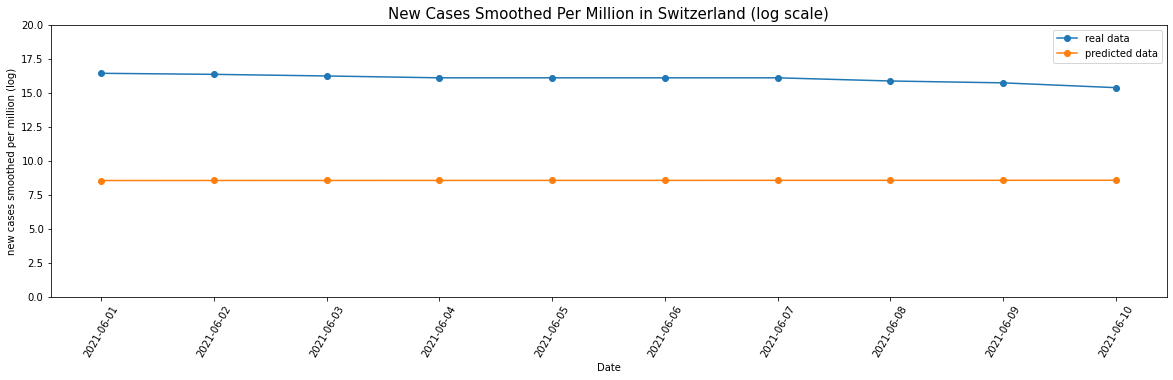

In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))
x = plot_df['Date']
plt.plot(x, plot_df['Jun_real_data_log'], 'o-', label = "real data")
plt.plot(x, plot_df['new_cases_smoothed_per_million_log'], 'o-', label = "predicted data")
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_tick_params(rotation = 60, labelsize = 10)
ax.legend()
ax.set_ylim(0, 20)
ax.set_xticks(x) 
plt.title('New Cases Smoothed Per Million in Switzerland (log scale)', fontsize = 15)
plt.xlabel('Date')
plt.ylabel('new cases smoothed per million (log)')
plt.show()

## New Cases Smoothed per Million vs. Total Vaccinations per Hundred

In the new cases smoothed per million vs. total vaccinations per hundred graph, it shows how the amount of new cases reacts with the amount of vaccinations increasing.  With the increment of the total vaccination per hundred, new cases per million predicted by our model slightly increases, while the actual data of new cases drop.

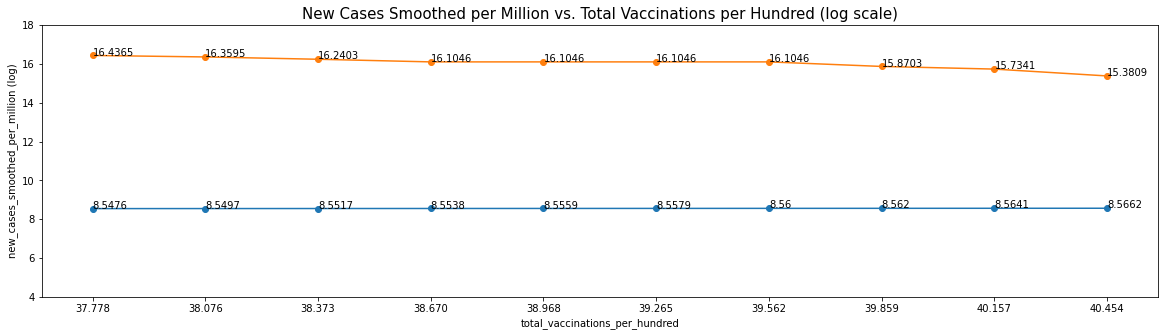

In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))
x = plot_df['Date']
plt.plot(plot_df['total_vaccinations_per_hundred'], plot_df['new_cases_smoothed_per_million_log'], 'o-')
plt.plot(plot_df['total_vaccinations_per_hundred'], plot_df['Jun_real_data_log'], 'o-')
ax.xaxis.set_major_locator(loc)
ax.set_ylim(4, 18) 
ax.set_xticks(plot_df['total_vaccinations_per_hundred'].values.tolist())
plt.title('New Cases Smoothed per Million vs. Total Vaccinations per Hundred (log scale)', fontsize = 15)
plt.xlabel('total_vaccinations_per_hundred')
plt.ylabel('new_cases_smoothed_per_million (log)')
new_cases_smoothed_per_million_log = [ round(elem, 4) for elem in plot_df['new_cases_smoothed_per_million_log'].values.tolist() ]
Jun_real_data_log = [ round(elem, 4) for elem in plot_df['Jun_real_data_log'].values.tolist() ]
for i, txt in enumerate(new_cases_smoothed_per_million_log):
    ax.annotate(txt, (plot_df['total_vaccinations_per_hundred'].values.tolist()[i], new_cases_smoothed_per_million_log[i]))
for i, txt in enumerate(Jun_real_data_log):
    ax.annotate(txt, (plot_df['total_vaccinations_per_hundred'].values.tolist()[i], Jun_real_data_log[i]))
plt.show()

## New Cases Smoothed Per Million in Switzerland

The graph shows the new cases predicted by our model for the future months, from 1st June to 31st August.  The new cases predicted by our model is expected to increase steadily throughout the period.

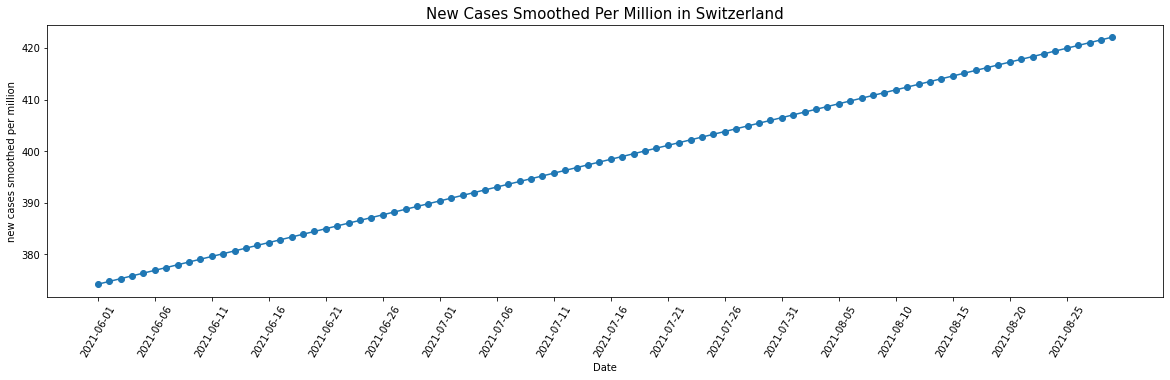

In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))
x = new_covid_org_swiss['Date']
plt.plot(x, new_covid_org_swiss['new_cases_smoothed_per_million'], 'o-')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_tick_params(rotation = 60, labelsize = 10)
ax.set_xticks([x[i] for i in range(0, len(x), 5)]) 
plt.title('New Cases Smoothed Per Million in Switzerland', fontsize = 15)
plt.xlabel('Date')
plt.ylabel('new cases smoothed per million')
plt.show()

# Conclusion
To look at our finalized data, we can be the first to critique our own process. With a unprecidented topic such as ours, encompassing so many incalculable variables, we found predicting the future to be even more difficult than anticipated. We could have played it safe by simply coming up with a process to predict the new cases for the months that were already covered in the dataset, but we wanted to predict future new cases. This means we needed to generate data for our predicitons. We decided to generate the data through linear regression, a simple yet efficient method. For our prediction, we used PanelOLS which is OLS for time-series data sets. PanelOLS was a good choice because it has lower constraints than other options. Our initial dataset had many missing values, even after selecting the features (columns) that we needed. To deal with this, we tried dropping the rows that contained missing values but then found there would be too few rows. Therefore, we decided to fill the missing values with an average of the columns. This decision made our process possible, but in retrospect it may have severely affected our results. Another issue we encountered was that our dataset contained data of different scales (for example: per hundred versus per million), yet set them all as equal variables. We devoted time in the attempt to combat this and multiple other issues that arose with our raw real-time data set, with lots of curveballs along the way. Although our final results have proven to be wide off the mark, to come together as computing students of various levels, to teach and learn together in the process of creating our pipeline, was extremely rewarding. The positive learning curve that came with this course was beneficial to every member of our group. As for the upcoming Corona outlook this summer: if we analyze the real-time data within our pipeline for this month, we can compare new cases with the vaccination rates and see a hopeful trend towards erradication.